In [1]:
# SETUP

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xarray as xr
from sklearn.model_selection import StratifiedShuffleSplit

import shap
import re

sns.set('paper', style='whitegrid')

In [5]:
INPUT_NAME = 'connectivities_classifier-SVML1_measure-accuracy_top-6_cv-100x4fold'

RESULTS = xr.open_dataset(f'models/{INPUT_NAME}.nc').load()
TOP_MODEL_NAMES = [name for name in RESULTS['model_name'].values[:3]]
# top_model_scores = scores.query('label in @top_model_names').sort_values('mean_test_score')
MODEL_COLORS = ['#1BA1E2', '#6A00FF', '#D80073', 'orange', 'black', 'red']
pallete = sns.color_palette(MODEL_COLORS)


RESULTS

<xarray.Dataset>
Dimensions:                                         (shap_dim: 800,
                                                     seitzman2018_feature: 105,
                                                     gordon2014_2mm_feature: 91,
                                                     dosenbach2010_feature: 21,
                                                     permutation_importance_num: 500,
                                                     subject: 32,
                                                     grid_model_name: 20,
                                                     model_name: 6,
                                                     cv_dim: 100,
                                                     permutation_dim: 10,
                                                     learning_curve_num: 5,
                                                     y_classes: 2)
Coordinates:
  * seitzman2018_feature                            (seitzman2018_feature) object ...
  * gordon2014_2mm_feature                          (gordon2014_2mm_feature) object ...
  * dosenbach2010_feature                           (dosenbach2010_feature) object ...
  * grid_model_name                                 (grid_model_name) object ...
  * model_name                                      (model_name) object 'dose...
  * learning_curve_num                              (learning_curve_num) int32 ...
  * y_classes                                       (y_classes) object 'AVGP'...
Dimensions without coordinates: shap_dim, permutation_importance_num, subject,
                                cv_dim, permutation_dim
Data variables: (12/151)
    seitzman2018 covariance shap                    (shap_dim, seitzman2018_feature) float64 ...
    seitzman2018 covariance shap data               (shap_dim, seitzman2018_feature) float64 ...
    gordon2014_2mm precision shap                   (shap_dim, gordon2014_2mm_feature) float64 ...
    gordon2014_2mm precision shap data              (shap_dim, gordon2014_2mm_feature) float64 ...
    gordon2014_2mm partial correlation shap         (shap_dim, gordon2014_2mm_feature) float64 ...
    gordon2014_2mm partial correlation shap data    (shap_dim, gordon2014_2mm_feature) float64 ...
    ...                                              ...
    learning_curve_train_size                       (learning_curve_num) int32 ...
    learning_curve_mean_train_score                 (learning_curve_num) float64 ...
    learning_curve_mean_test_score                  (learning_curve_num) float64 ...
    cv_test_size                                    int32 8
    cv_n_splits                                     int32 100
    n_subjects                                      int32 32

In [3]:
# prep grid data

n_subjects = RESULTS['n_subjects'].item()
X = RESULTS['X'].values
y = RESULTS['y'].values
cv_n_splits = RESULTS['cv_n_splits'].item()
cv_test_size = RESULTS['cv_test_size'].item()
scoring = RESULTS['scoring'].item()


split_score_cols = [c for c in list(RESULTS.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = RESULTS[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: ' '.join(p.values()))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)

scores[['atlas','kind']] = scores['label'].apply(
    lambda x: x.replace('partial correlation', 'partial_correlation').split(' ')).apply(pd.Series)

scores = scores[['label', 'atlas', 'kind', 'test_score', 'mean_test_score']]

# simulate chance
chance_scores = {}
for model_name in scores['label'].unique():
    chance_model = DummyClassifier(strategy='stratified').fit(X, y)
    _chance_scores = cross_val_score(chance_model, X, y,
                                     cv=StratifiedShuffleSplit(n_splits=cv_n_splits, test_size=cv_test_size), scoring=scoring)
    chance_scores[model_name] = _chance_scores

chance_scores = pd.DataFrame(chance_scores)
chance_scores = chance_scores.melt(value_name=scoring, var_name='label')

# sort, mean score and ordering
scores = scores.sort_values('mean_test_score', ascending=True)
mean_scores = scores.groupby('label')[['test_score']].mean().reset_index()
order = scores['label'].drop_duplicates()

# percentage accuracy
scores['accuracy_pct'] = scores['test_score'] * 100.0
chance_scores['accuracy_pct'] = chance_scores['accuracy'] * 100.0
mean_scores['accuracy_pct'] = mean_scores['test_score'] * 100.0


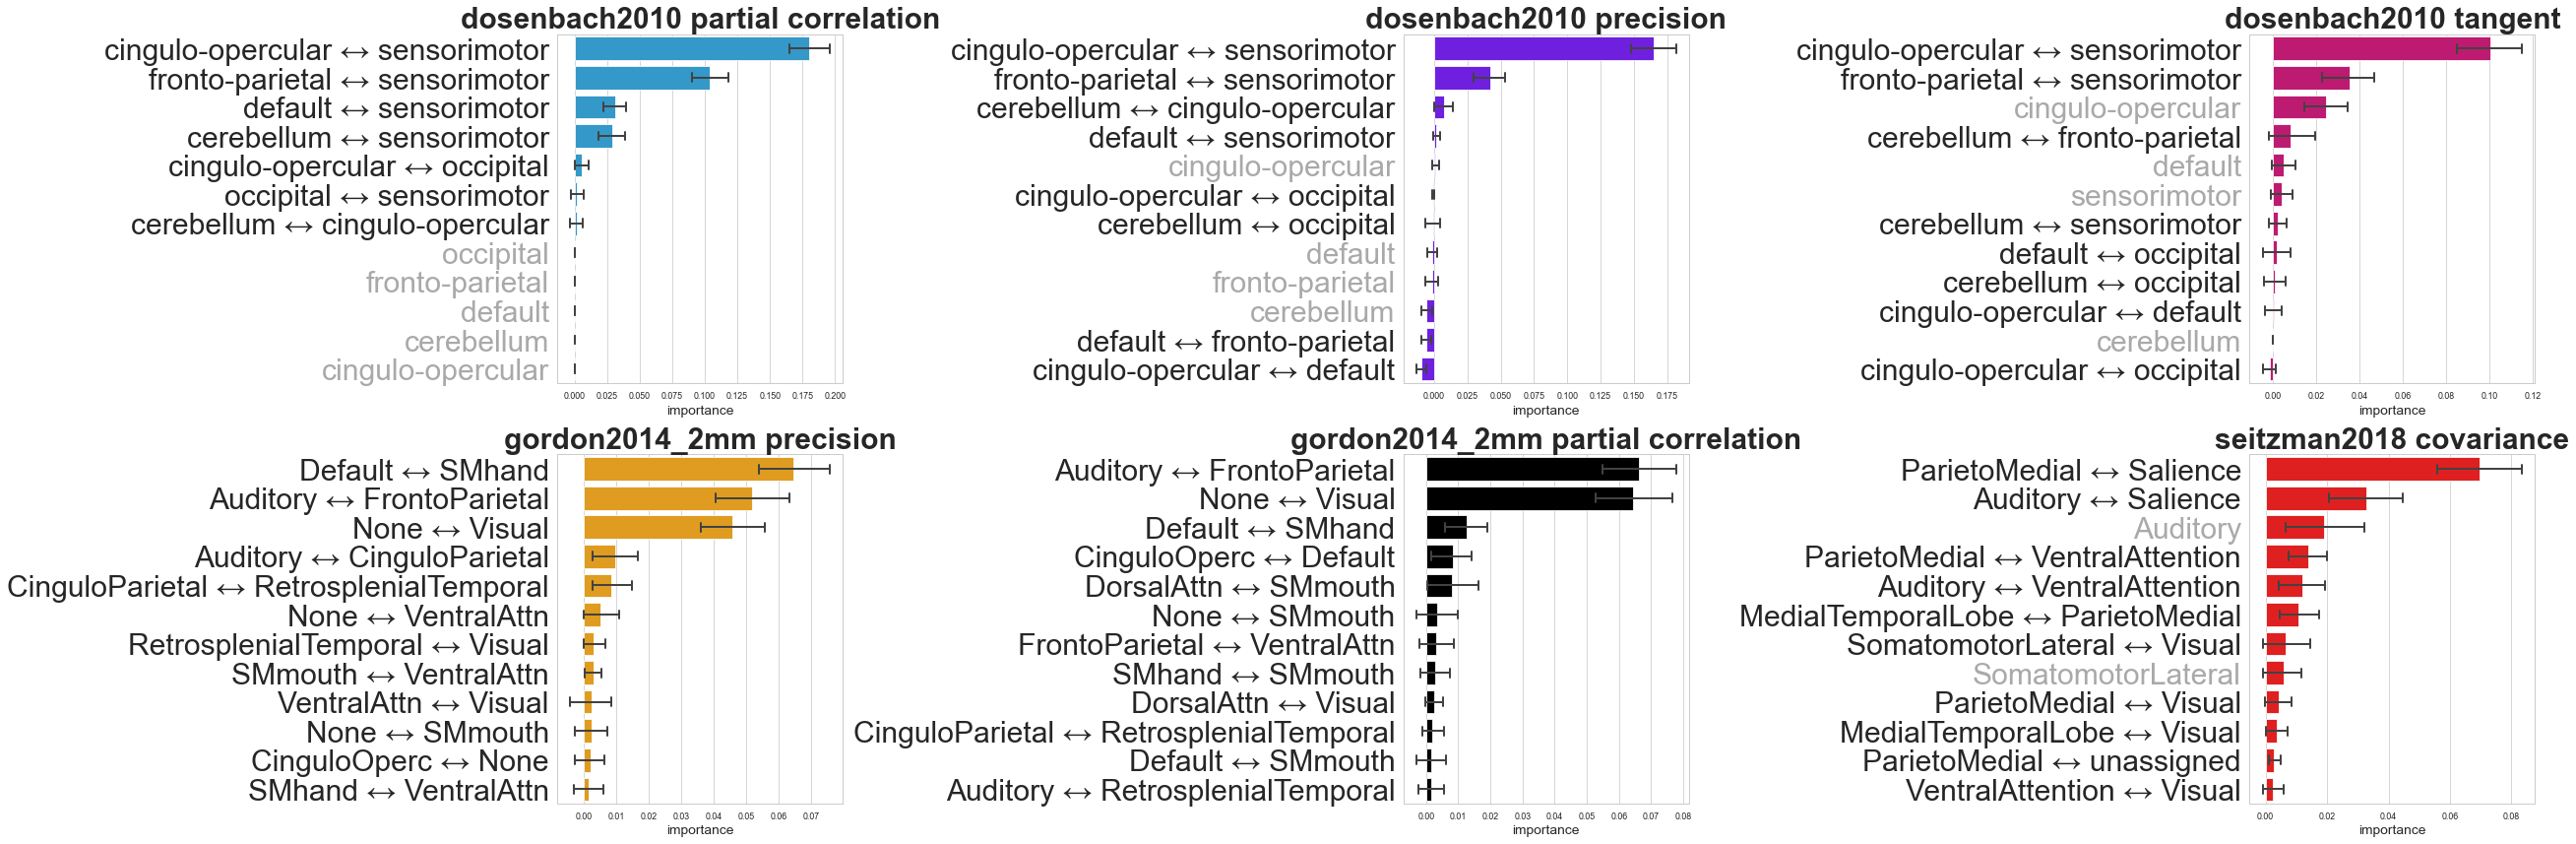

In [8]:
def plot_feature_importance(results, model_name, n_features=-1, ax=None):

    top_model_names = results['model_name'].values.tolist()
    color = MODEL_COLORS[top_model_names.index(model_name)]
    
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 15))

    perm_imp_scores = results[f'{model_name} importances'].to_pandas()

    perm_imp_order = perm_imp_scores.mean().sort_values(ascending=False).index.to_list()
    perm_imp_order = perm_imp_order[:n_features]

    g = sns.barplot(data=perm_imp_scores,
                order=perm_imp_order,
                orient='horizontal',
                capsize=.3,
                errwidth=2,
                color=color,
                ax=ax)

    g.set_yticklabels(g.get_yticklabels(), fontsize=30)
    g.set_ylabel('')
    g.set_xlabel('importance', fontsize='x-large')

    for tick in g.get_yticklabels():
        if '\N{left right arrow}' not in str(tick):
            tick.set_color('darkgray')

top_model_names = [f'{name}' for name in RESULTS['model_name'].values]

_, axes = plt.subplots(2,len(top_model_names) // 2,
                       figsize=(len(top_model_names)*6,12), sharey=False, squeeze=False)

for i, (model_name, ax) in enumerate(zip(top_model_names, axes.flatten())):
    plot_feature_importance(RESULTS, model_name, ax=ax, n_features=12)
    ax.set_title(model_name, fontsize=30, fontweight='bold')
    

# plt.suptitle('Permutation importance (impact on model accuracy)', fontsize='xx-large')

plt.tight_layout()
plt.show()